In [5]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr,spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from pymer4.models import Lmer

import nibabel as nib
from nltools.data import Brain_Data, Adjacency

from sklearn.metrics import pairwise_distances
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def regress_out(vec, control_matrices):
    # 获取上三角部分的索引
    upper_triangle_indices = np.triu_indices_from(vec, k=1)

    if control_matrices is None or len(control_matrices) == 0:
        return vec  # 如果没有控制变量，直接返回原始矩阵

    # 对原始矩阵进行标准化
    scaler = StandardScaler()
    vec_scaled = scaler.fit_transform(vec[upper_triangle_indices].reshape(-1, 1)).flatten()

    # 收集控制变量的标准化版本
    control_vectors = []
    for control_matrix in control_matrices:
        control_vec = control_matrix[upper_triangle_indices]
        control_vec_scaled = scaler.fit_transform(control_vec.reshape(-1, 1)).flatten()
        control_vectors.append(control_vec_scaled)
    
    # 拼接控制变量矩阵
    control_matrix = np.column_stack(control_vectors)

    # 执行回归
    model = LinearRegression().fit(control_matrix, vec_scaled)

    # 计算残差
    residuals = vec_scaled - model.predict(control_matrix)
    
    # 将残差放回原始矩阵的上三角部分
    vec_residual = np.zeros_like(vec)
    vec_residual[upper_triangle_indices] = residuals

    # 由于矩阵是对称的，将残差填充回下三角部分
    vec_residual = vec_residual + vec_residual.T

    return vec_residual


In [171]:
    
def plot_regression_surface(save_path=None):
    coefs = model.coefs
    intercept = coefs.loc['(Intercept)', 'Estimate']
    beta_change_progress = coefs.loc['change_progress', 'Estimate']
    beta_joint_IUS = coefs.loc['joint_IUS', 'Estimate']
    beta_interaction = coefs.loc['change_progress:joint_IUS', 'Estimate']
    change_progress_range = np.linspace(-3, 3, 50)
    joint_IUS_range = np.linspace(-3, 3, 50)
    X, Y = np.meshgrid(change_progress_range, joint_IUS_range)
    Z = intercept + beta_change_progress * X + beta_joint_IUS * Y + beta_interaction * X * Y
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.zaxis.set_ticks_position('lower')  
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='z', labelsize=16) 
    plt.tight_layout()
    if save_path:
        plt.savefig(f'/Users/li/Desktop/Figure/{save_path}.png', dpi=300)
    plt.show()

def plot_marginal_effects(save_path=None):
    intercept = model.coefs.iloc[0, 0]
    beta_change_progress = model.coefs.iloc[1, 0]
    beta_joint_IUS = model.coefs.iloc[2, 0]
    beta_interaction = model.coefs.iloc[3, 0]
    change_progress_range = np.linspace(-3, 3, 100)
    joint_IUS_range = [df['joint_IUS'].quantile(0.25), df['joint_IUS'].quantile(0.75)]  # Q1, Q3
    pred_data = pd.DataFrame({
        'change_progress': np.tile(change_progress_range, 2),
        'joint_IUS': np.concatenate([np.repeat(joint_IUS_range[0], len(change_progress_range)),
                                     np.repeat(joint_IUS_range[1], len(change_progress_range))])
    })
    pred_data['predicted_ISC'] = intercept + beta_change_progress * pred_data['change_progress'] + \
                                 beta_joint_IUS * pred_data['joint_IUS'] + \
                                 beta_interaction * pred_data['change_progress'] * pred_data['joint_IUS']
    plt.figure(figsize=(4, 3))
    pred_data['Joint IUS'] = np.where(pred_data['joint_IUS'] == joint_IUS_range[0], 'Q1', 'Q3')
    muted_colors = sns.color_palette("muted")
    sns.lineplot(data=pred_data, x='change_progress', y='predicted_ISC', hue='Joint IUS', linewidth=4, palette=[muted_colors[0], muted_colors[3]])
    plt.gca().set_facecolor('white')  # 背景设置为白色
    plt.gca().spines['top'].set_visible(False)  # 去掉上框线
    plt.gca().spines['right'].set_visible(False)  # 去掉右框线
    plt.gca().spines['left'].set_linewidth(1.5)  # 设置左框线宽度
    plt.gca().spines['bottom'].set_linewidth(1.5)  # 设置下框线宽度
    plt.gca().grid(False)  # 关闭网格线
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Joint IU", fontsize=14, title_fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(f'/Users/li/Desktop/Figure/{save_path}.png', dpi=300)
    plt.show()


## dACC

In [173]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)
print(all_brain_data.shape)

mask_file = '/Users/li/Desktop/template/Schaefer/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata()

nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
roi_name = list(nw_labels['ROI Name'])


(37, 1493, 200)


In [174]:
brain_correlation_matrices = []

for node in range(all_brain_data.shape[2]):
    brain_correlation_matrices.append(Adjacency(1 - pairwise_distances(all_brain_data[:, :, node], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(brain_correlation_matrices)

brain_ISC_np = np.array(brain_ISC.squareform())
print(brain_ISC_np.shape)

brain_ISC_Z_np = np.arctanh(brain_ISC_np)
adjs = []
for i in range(200):
    iscz = brain_ISC_Z_np[i]
    adjs.append(Adjacency(iscz, is_symmetric=True))
brain_ISC_Z = Adjacency(adjs)

# sns.heatmap(brain_ISC_np.mean(0))
# sns.heatmap(isc_z.mean(0))

(200, 37, 37)


In [177]:
bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'

sub_list_num = list(range(13,51))
sub_list_num.remove(21)

# time_points = list(range(0,3000,60)) + [2986]  # every 1 minute
time_points = list(range(0,3000,120)) + [2986] # every 2 min
# time_points = list(range(0,3000,300)) + [2986] # every 5 min
# time_points = [0, 252, 500, 772, 1098, 1484, 1892, 2464, 2986] # every speaker
# time_points = list(range(0,2987,2)) # every TR


all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
    
attitude = pd.DataFrame(all_subject_data)

start_attitude = pd.DataFrame(attitude)[0]
start_attitude_SM = -np.abs(start_attitude.values[:, np.newaxis] - start_attitude.values)

attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
print(attitude_change.shape)

attitude_change_distances = -pdist(attitude_change)
# attitude_change_distances = -np.sqrt(pdist(attitude_change))
# attitude_change_distances = -np.log(pdist(attitude_change))
attitude_change_distances_matrix = squareform(attitude_change_distances)
print(attitude_change_distances_matrix.shape)


attitude_change_reg = regress_out(attitude_change_distances_matrix, [age_diff_matrix, sex_diff_matrix, start_attitude_SM])


(37, 25)
(37, 37)


In [179]:

subjects = list(range(13,51))
subjects.remove(21)

personality = pd.read_csv('/Users/li/Desktop/task-debate/behavdata/questionire_data/personality.csv')

selected_data = personality[personality['sub'].isin(subjects)]
selected_data = selected_data.set_index('sub').loc[subjects]

ages = selected_data['age'].values
age_diff_matrix = np.abs(ages[:, np.newaxis] - ages)

sex = selected_data['sex'].values
sex_diff_matrix = np.abs(sex[:, np.newaxis] - sex)

IUS = selected_data['IUS'].values
joint_IUS = (IUS[:, np.newaxis] + IUS)/2



In [181]:
persons = np.arange(len(subjects))  

def matrix2long(roi):
    
    data = {'Person1': [], 'Person2': [], 
            'start': [], 'change_progress':[], 'ISC':[],
            'age':[], 'sex':[], 'joint_IUS':[]
           }
    
    for i in persons:
        for j in persons:
            if i != j:  # 忽略自身配对
                data['Person1'].append(i)
                data['Person2'].append(j)
                data['start'].append(start_attitude_SM[i, j])
                data['change_progress'].append(attitude_change_reg[i, j])
                data['age'].append(age_diff_matrix[i, j])
                data['sex'].append(sex_diff_matrix[i, j])
                data['joint_IUS'].append(joint_IUS[i, j])
                data['ISC'].append(regress_out(brain_ISC_Z_np[roi,:,:], [age_diff_matrix, sex_diff_matrix, start_attitude_SM])[i,j]) 
                
    df = pd.DataFrame(data)
    X = df[['start','change_progress','age', 'sex', 'joint_IUS', 'ISC']]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    df_standardized = df.copy()
    df_standardized[['start', 'change_progress', 'age', 'sex', 'joint_IUS', 'ISC']] = X_standardized

    return df_standardized

def get_coef(item):
    params.append(model_coefs_df['Estimate'][item])
    se.append(model_coefs_df['SE'][item])
    degree.append(model_coefs_df['DF'][item])
    t.append(model_coefs_df['T-stat'][item])
    p.append(model_coefs_df['P-val'][item])



In [183]:
formula = "ISC ~ change_progress * joint_IUS + (1|Person1) + (1|Person2)"
df = matrix2long(89)

model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.001957,-0.191410,0.187496,0.096661,62.901445,-0.020245,9.839116e-01,
change_progress,0.220929,0.138139,0.303719,0.042240,583.505360,5.230274,2.362637e-07,***
joint_IUS,-0.041051,-0.176642,0.094541,0.069181,69.834999,-0.593385,5.548403e-01,
change_progress:joint_IUS,0.073367,0.017825,0.128910,0.028339,1313.282266,2.588946,9.733375e-03,**


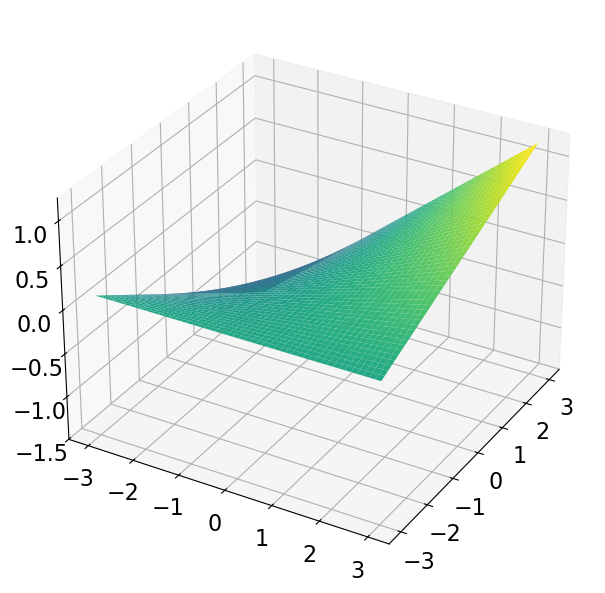

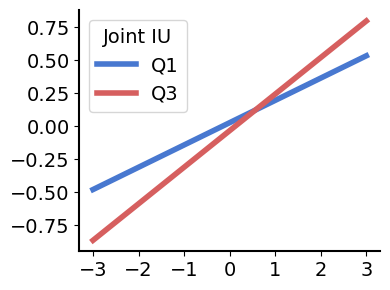

In [185]:
plot_regression_surface(save_path = '7c_dACC')
plot_marginal_effects(save_path = '7d_dACC')

# dACC-region dISFC (each edge)

In [187]:
subs_dISFC = np.load('/Users/li/Desktop/debate2025/results/subs_dISFC_seed89.npy')
subs_dISFC = np.arctanh(subs_dISFC)
intersub_dISFC_similarity = []
for edge in range(subs_dISFC.shape[1]):
    intersub_dISFC_similarity .append(Adjacency(1 - pairwise_distances(subs_dISFC[:, edge, :], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(intersub_dISFC_similarity )

brain_ISC_np = np.array(brain_ISC.squareform())
print(brain_ISC_np.shape)

brain_ISC_Z_np = np.arctanh(brain_ISC_np)

persons = np.arange(len(subjects))  

# from pymer4.models import Lmer
def matrix2long(roi):
    
    data = {'Person1': [], 'Person2': [], 
            'start': [], 'change_progress':[], 'ISC':[],
            'age':[], 'sex':[], 'joint_IUS':[],
           }
    
    for i in persons:
        for j in persons:
            if i != j:  # 忽略自身配对
                data['Person1'].append(i)
                data['Person2'].append(j)
                data['start'].append(start_attitude_SM[i, j])
                data['change_progress'].append(attitude_change_reg[i, j])
                data['age'].append(age_diff_matrix[i, j])
                data['sex'].append(sex_diff_matrix[i, j])
                data['joint_IUS'].append(joint_IUS[i, j])
                data['ISC'].append(regress_out(brain_ISC_Z_np[roi,:,:], [age_diff_matrix, sex_diff_matrix, start_attitude_SM])[i,j])
                
    df = pd.DataFrame(data)
    X = df[['start','change_progress','age', 'sex', 'joint_IUS', 'ISC']]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    df_standardized = df.copy()
    df_standardized[['start', 'change_progress', 'age', 'sex', 'joint_IUS', 'ISC']] = X_standardized

    return df_standardized

def get_coef(item):
    params.append(model_coefs_df['Estimate'][item])
    se.append(model_coefs_df['SE'][item])
    degree.append(model_coefs_df['DF'][item])
    t.append(model_coefs_df['T-stat'][item])
    p.append(model_coefs_df['P-val'][item])



(199, 37, 37)


In [77]:
results = pd.read_csv('/Users/li/Desktop/debate2025/results/ISFC-ISRSA-Exp1-seed89-2min.csv')

indices = results[results['p1'] < 0.05].index
indices


Index([  5,  13,  22,  31,  34,  37,  51,  57,  63,  76,  80,  84,  86,  91,
        93,  95,  97, 105, 161, 167, 175, 180, 181, 184, 185, 186, 192, 193,
       197, 198],
      dtype='int64')

In [79]:
print(list(results[results['p1'] < 2].index))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]


In [81]:
roi_list1 = [5,  13,  22,  31,  34,  37,  51,  57,  63,  76,  80,  84,  86]
roi_list2 = [91, 93,  95,  97, 105, 161, 167, 175, 180, 181, 184, 185, 186, 192, 193, 197, 198]
roi_list = roi_list1 +  roi_list2
print(roi_list)
formula = "ISC ~ change_progress * joint_IUS + (1|Person1) + (1|Person2)"

params, se, degree, t, p = [], [], [], [], []
for roi in roi_list:
    df = matrix2long(roi)
    model = Lmer(formula, data=df)
    model.fit(summary=False)
    model_coefs_df = model.coefs
    get_coef('change_progress:joint_IUS')

params0, se0, degree0, t0, p0 = params, se, degree, t, p

[5, 13, 22, 31, 34, 37, 51, 57, 63, 76, 80, 84, 86, 91, 93, 95, 97, 105, 161, 167, 175, 180, 181, 184, 185, 186, 192, 193, 197, 198]


In [82]:
params, se, degree, t, p = [], [], [], [], []
for roi in roi_list:
    df = matrix2long(roi)
    model = Lmer(formula, data=df)
    model.fit(summary=False)
    model_coefs_df = model.coefs
    get_coef('change_progress')
params1, se1, degree1, t1, p1 = params, se, degree, t, p

In [83]:
params, se, degree, t, p = [], [], [], [], []
for roi in roi_list:
    df = matrix2long(roi)
    model = Lmer(formula, data=df)
    model.fit(summary=False)
    model_coefs_df = model.coefs
    get_coef('joint_IUS')
params2, se2, degree2, t2, p2 = params, se, degree, t, p

In [84]:
p_list_all = p0 + p1 + p2
adjusted_pvals_all = multipletests(p_list_all, alpha=0.05, method='fdr_bh')[1]

for i,p_ in enumerate(adjusted_pvals_all[:30]):
    if p_<0.05:
        print(roi_list[i],params0[i], se0[i], t0[i], p_)


34 0.0871668622328556 0.030812992045212616 2.828899644181053 0.014758661215573355
37 0.0994807675479037 0.030233076440966185 3.2904612847505676 0.004406494037393895
84 0.08464192884253881 0.030110058810234323 2.811084806442466 0.015045509684205616
97 0.11214335220590904 0.031139159669730566 3.6013609036123153 0.002126572072460949
197 0.075373398089329 0.030644801019223702 2.4595819056565817 0.03618068564562092
198 0.12446263476853296 0.02996179464223176 4.154044717772024 0.00044898738662377323


## 97 

In [135]:
df = matrix2long(97)
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.002991,-0.144361,0.138379,0.072129,53.992753,-0.041471,0.967074,
change_progress,0.105998,0.024770,0.187226,0.041444,266.675177,2.557653,0.011092,*
joint_IUS,-0.019920,-0.124559,0.084718,0.053388,68.581278,-0.373124,0.710207,
change_progress:joint_IUS,0.112143,0.051112,0.173175,0.031139,1090.961594,3.601361,0.000331,***


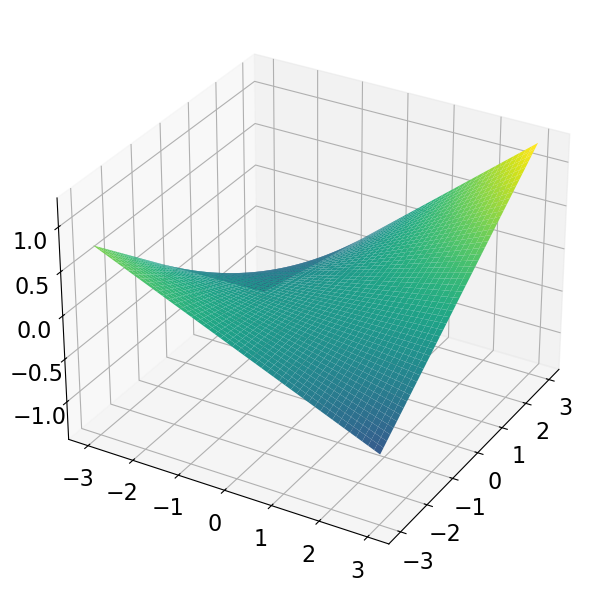

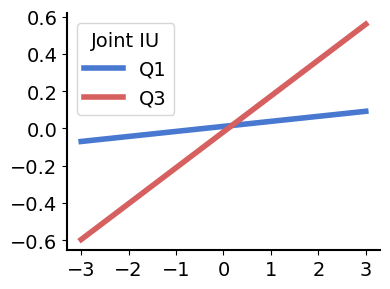

In [159]:
plot_regression_surface(save_path = '7c97')
plot_marginal_effects(save_path = '7d97')

## 197 

In [162]:
df = matrix2long(197)
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.002010,-0.135661,0.131640,0.068190,53.245412,-0.029483,9.765895e-01,
change_progress,0.207016,0.128202,0.285829,0.040212,249.282533,5.148127,5.340374e-07,***
joint_IUS,0.057823,-0.041645,0.157291,0.050750,69.125884,1.139371,2.584811e-01,
change_progress:joint_IUS,0.075373,0.015311,0.135436,0.030645,1049.657967,2.459582,1.407027e-02,*


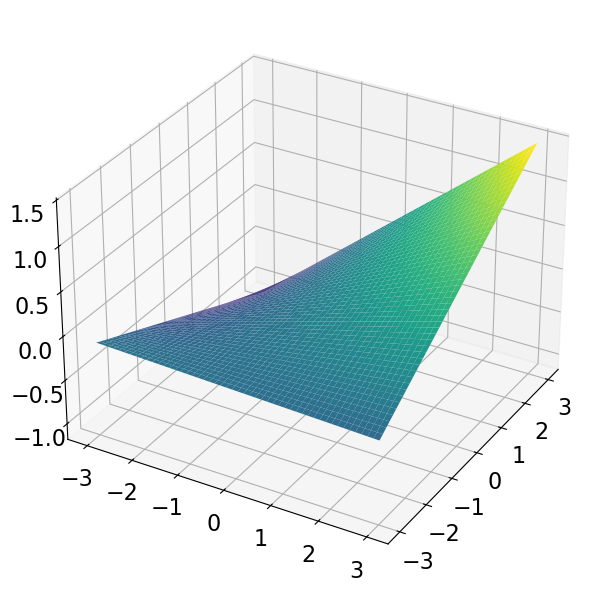

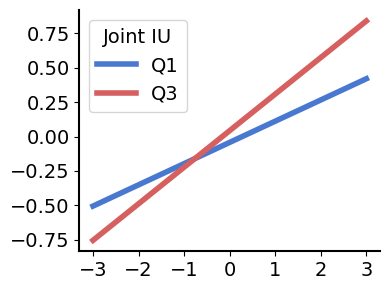

In [164]:
plot_regression_surface(save_path = '7c197')
plot_marginal_effects(save_path = '7d197')

## 198 

In [167]:
df = matrix2long(198)
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.003320,-0.163583,0.156943,0.081768,59.569579,-0.040600,0.967750,
change_progress,0.202612,0.120162,0.285062,0.042067,375.419722,4.816408,0.000002,***
joint_IUS,-0.014103,-0.130629,0.102423,0.059453,70.437264,-0.237209,0.813184,
change_progress:joint_IUS,0.124463,0.065739,0.183187,0.029962,1229.959338,4.154045,0.000035,***


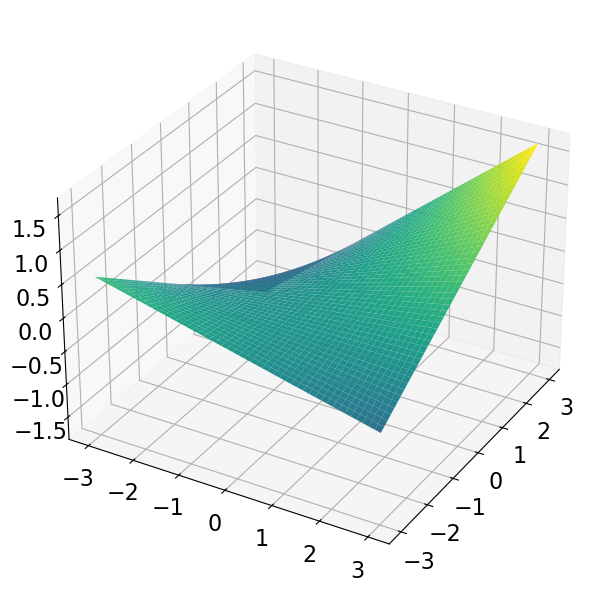

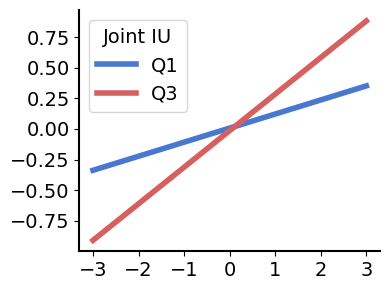

In [169]:
plot_regression_surface(save_path = '7c198')
plot_marginal_effects(save_path = '7d198')

## 84

In [193]:
df = matrix2long(84)
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.002258,-0.166245,0.161730,0.083669,59.823653,-0.026984,0.978563,
change_progress,0.157832,0.074525,0.241139,0.042504,388.699253,3.713304,0.000234,***
joint_IUS,-0.086985,-0.206030,0.032059,0.060738,70.291739,-1.432135,0.156537,
change_progress:joint_IUS,0.084642,0.025627,0.143657,0.030110,1240.408301,2.811085,0.005015,**


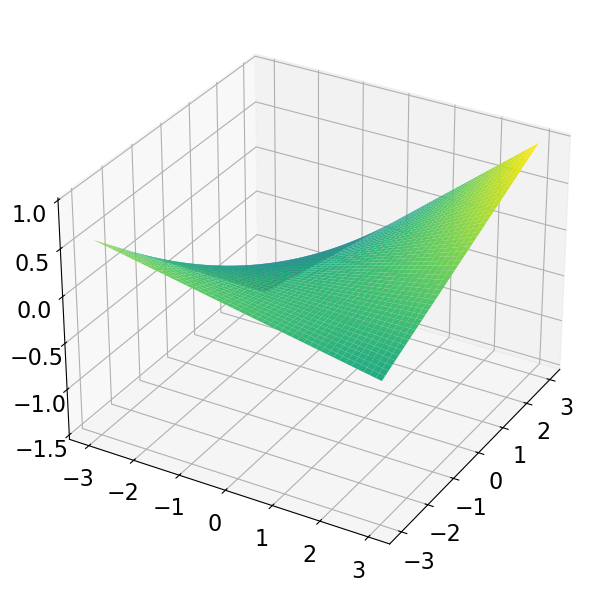

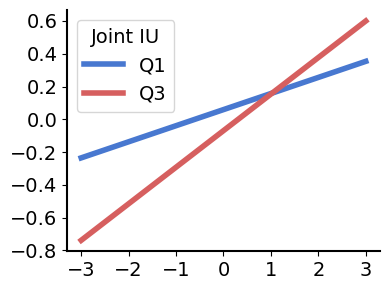

In [196]:
plot_regression_surface(save_path = '7c84')
plot_marginal_effects(save_path = '7d84')

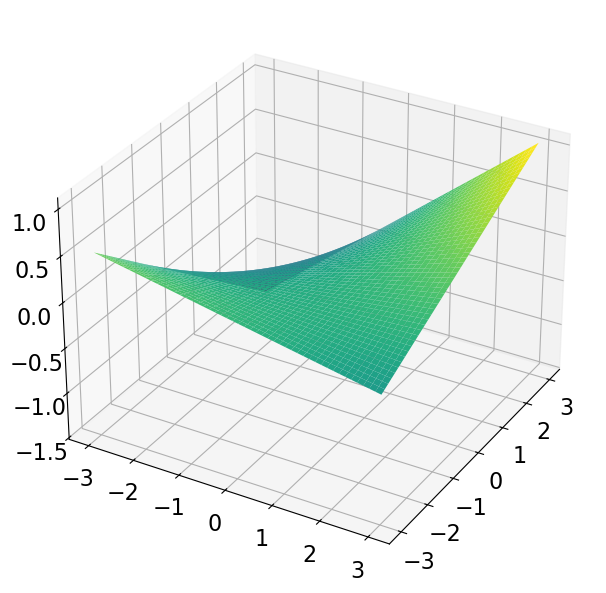

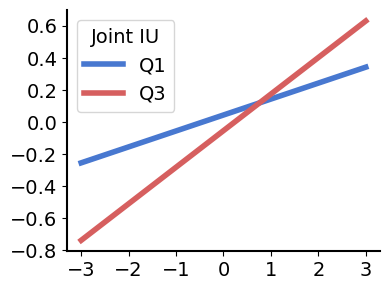

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.002325,-0.143052,0.138402,0.071801,55.363384,-0.032382,0.974284,
change_progress,0.160948,0.080404,0.241492,0.041095,274.645750,3.916519,0.000113,***
joint_IUS,-0.066154,-0.170236,0.037928,0.053104,70.087223,-1.245739,0.217009,
change_progress:joint_IUS,0.087167,0.026775,0.147559,0.030813,1101.424010,2.828900,0.004756,**


In [198]:
df = matrix2long(34)
model = Lmer(formula, data=df)
model.fit(summary=False)
plot_regression_surface(save_path = '7c34')
plot_marginal_effects(save_path = '7d34')
model.coefs

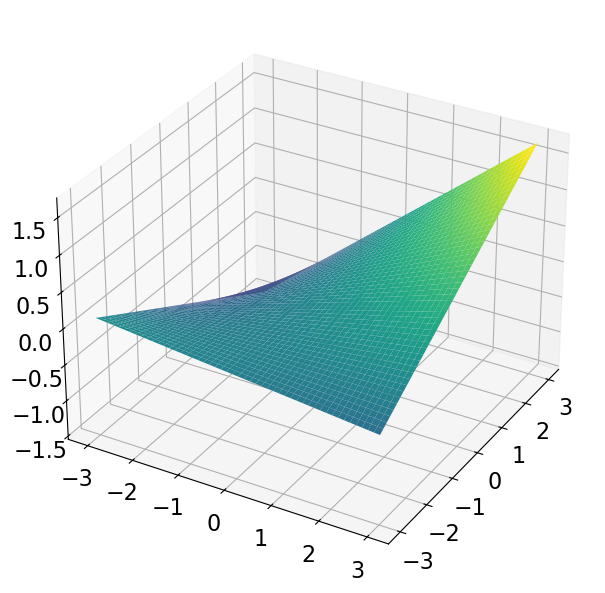

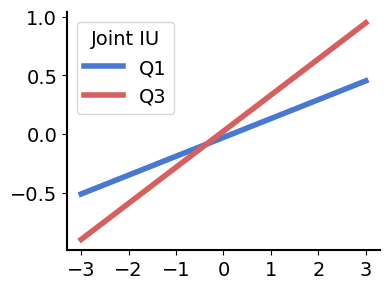

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.002653,-0.169879,0.164572,0.085321,59.277175,-0.031100,9.752942e-01,
change_progress,0.230565,0.146535,0.314595,0.042873,396.829896,5.377839,1.290185e-07,***
joint_IUS,0.036099,-0.085138,0.157336,0.061857,69.293417,0.583593,5.613890e-01,
change_progress:joint_IUS,0.099481,0.040225,0.158737,0.030233,1247.799215,3.290461,1.028182e-03,**


In [200]:
df = matrix2long(37)
model = Lmer(formula, data=df)
model.fit(summary=False)
plot_regression_surface(save_path = '7c37')
plot_marginal_effects(save_path = '7d37')
model.coefs

# average dACC-DMN dISFC

In [29]:
subs_dISFC = np.load('/Users/li/Desktop/debate2025/results/subs_dISFC_seed89.npy')
subs_dISFC = np.arctanh(subs_dISFC)
intersub_dISFC_similarity = []
for edge in range(subs_dISFC.shape[1]):
    intersub_dISFC_similarity .append(Adjacency(1 - pairwise_distances(subs_dISFC[:, edge, :], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(intersub_dISFC_similarity )

brain_ISC_np = np.array(brain_ISC.squareform())
print(brain_ISC_np.shape)

brain_ISC_Z_np = np.arctanh(brain_ISC_np)



(199, 37, 37)


In [30]:
nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
nw_labels = nw_labels[nw_labels["ROI Label"] != 90].reset_index(drop=True)

default = []
for i in range(199):
    net_name = nw_labels['ROI Name'][i].split('_')[2] 
    if net_name == 'Default':
        default.append(i)

DMN_ISC_Z_np = brain_ISC_Z_np[default,:,:].mean(0)
DMN_ISC_Z_np.shape

(37, 37)

In [31]:


persons = np.arange(len(subjects))  

# from pymer4.models import Lmer
def matrix2long():
    
    data = {'Person1': [], 'Person2': [], 
            'start': [], 'change_progress':[], 'ISC':[],
            'age':[], 'sex':[], 'joint_IUS':[],
           }
    
    for i in persons:
        for j in persons:
            if i != j:  # 忽略自身配对
                data['Person1'].append(i)
                data['Person2'].append(j)
                data['start'].append(start_attitude_SM[i, j])
                data['change_progress'].append(attitude_change_reg[i, j])
                # data['change_progress'].append(attitude_change_distances_matrix[i, j])
                data['age'].append(age_diff_matrix[i, j])
                data['sex'].append(sex_diff_matrix[i, j])
                data['joint_IUS'].append(joint_IUS[i, j])
                data['ISC'].append(regress_out(DMN_ISC_Z_np, [age_diff_matrix, sex_diff_matrix, start_attitude_SM])[i,j]) 
                # data['ISC'].append(DMN_ISC_Z_np[i,j]) 
    df = pd.DataFrame(data)
    X = df[['start','change_progress','age', 'sex', 'joint_IUS', 'ISC']]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    df_standardized = df.copy()
    df_standardized[['start', 'change_progress', 'age', 'sex', 'joint_IUS', 'ISC']] = X_standardized

    return df_standardized

def get_coef(item):
    params.append(model_coefs_df['Estimate'][item])
    se.append(model_coefs_df['SE'][item])
    degree.append(model_coefs_df['DF'][item])
    t.append(model_coefs_df['T-stat'][item])
    p.append(model_coefs_df['P-val'][item])



In [33]:
formula = "ISC ~ change_progress * joint_IUS + (1|Person1) + (1|Person2)"
df = matrix2long()

model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.001295,-0.183217,0.180626,0.092819,61.917455,-0.013957,0.988909,
change_progress,0.165765,0.081568,0.249963,0.042959,502.844622,3.858713,0.000129,***
joint_IUS,-0.027319,-0.158112,0.103475,0.066733,69.999641,-0.409373,0.683516,
change_progress:joint_IUS,0.048567,-0.008985,0.106120,0.029364,1295.292959,1.653975,0.098375,.


In [18]:
# debate date；controled；seed 89；

roi_list1 = [5,  22,  34,  37,  50,  51,  57,  63,  76,  80,  86]
roi_list2 = [item +1 for item in [89,  93,  95, 161, 181, 184, 186, 192, 193, 197, 198]]
roi_list = roi_list1 +  [89] + roi_list2
roi_list.sort()
print(len(roi_list))


23


In [19]:
from nltools.stats import isfc
select_roi_data = all_brain_data[:,:,roi_list]
print(select_roi_data.shape)
ISFC = np.array(isfc(select_roi_data))

ISFC_Z = np.arctanh(ISFC)
print(ISFC_Z.shape)
mean_ISFC = []
for sub in range(ISFC_Z.shape[0]):
    sub_IFSC = (ISFC_Z[sub] + ISFC_Z[sub].T)/2
    mean_ISFC.append(sub_IFSC)
mean_ISFC = np.array(mean_ISFC)
print(mean_ISFC.shape)


(37, 1493, 23)
(37, 23, 23)
(37, 23, 23)


In [20]:
index_of_89 = roi_list.index(89)
print(index_of_89)

seed89_ISFC = np.array([np.delete(subject[:,index_of_89], index_of_89) for subject in ISFC_Z])
# seed89_ISFC = np.array([np.delete(subject[index_of_89,:], index_of_89) for subject in ISFC_Z])
print(seed89_ISFC.shape)

corr_matrix = np.corrcoef(seed89_ISFC)

corr_matrix = np.arctanh(corr_matrix)


11
(37, 22)


In [21]:


persons = np.arange(len(subjects))  

from pymer4.models import Lmer
def matrix2long():
    
    data = {'Person1': [], 'Person2': [], 
            'start': [], 'change_progress':[], 'ISC':[],
            'age':[], 'sex':[], 'joint_IUS':[],
           }
    
    for i in persons:
        for j in persons:
            if i != j:  # 忽略自身配对
                data['Person1'].append(i)
                data['Person2'].append(j)
                data['start'].append(start_attitude_SM[i, j])
                data['change_progress'].append(attitude_change_reg[i, j])
                data['age'].append(age_diff_matrix[i, j])
                data['sex'].append(sex_diff_matrix[i, j])
                data['joint_IUS'].append(joint_IUS[i, j])
                data['ISC'].append(regress_out(corr_matrix, [age_diff_matrix, sex_diff_matrix, start_attitude_SM])[i,j]) 
                
    df = pd.DataFrame(data)
    X = df[['start','change_progress','age', 'sex', 'joint_IUS', 'ISC']]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    df_standardized = df.copy()
    df_standardized[['start', 'change_progress', 'age', 'sex', 'joint_IUS', 'ISC']] = X_standardized

    return df_standardized

def get_coef(item):
    params.append(model_coefs_df['Estimate'][item])
    se.append(model_coefs_df['SE'][item])
    degree.append(model_coefs_df['DF'][item])
    t.append(model_coefs_df['T-stat'][item])
    p.append(model_coefs_df['P-val'][item])



In [22]:
df = matrix2long()

formula = "ISC ~ change_progress * joint_IUS + (1|Person1) + (1|Person2)"
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.000695,-0.255761,0.254370,0.130138,65.168398,-0.005344,0.995753,
change_progress,0.059201,-0.012511,0.130914,0.036589,1180.997076,1.618022,0.105925,
joint_IUS,0.110617,-0.068796,0.290031,0.091539,67.515945,1.208414,0.231104,
change_progress:joint_IUS,0.026073,-0.018074,0.070219,0.022524,1310.015729,1.157546,0.247260,


# pattern of dACC-DMN dISFC

In [38]:
nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
nw_labels = nw_labels[nw_labels["ROI Label"] != 90].reset_index(drop=True)

vis, sm, da, va, limb, cont, default = [],[],[],[],[],[],[]
for i in range(199):
    net_name = nw_labels['ROI Name'][i].split('_')[2] 
    if net_name == 'Vis':
        vis.append(i)
    elif net_name == 'SomMot':
        sm.append(i)
    elif net_name == 'DorsAttn':
        da.append(i)
    elif net_name == 'SalVentAttn':
        va.append(i)
    elif net_name == 'Limbic':
        limb.append(i)
    elif net_name == 'Cont':
        cont.append(i)
    elif net_name == 'Default':
        default.append(i)
        
nets = [vis, sm, da, va, limb, cont, default]
nets_name = ['vis', 'sm', 'da', 'va', 'limb', 'cont', 'default']
    

net = default
subs_default_dISFC = subs_dISFC[:,net,:]

distance_matrices = np.zeros((37, len(net), len(net)))
for i in range(37):
    subject_data = subs_default_dISFC[i]  # (1464, 45)
    corr_matrix = np.corrcoef(subject_data)  # 皮尔逊相关系数
    distance_matrices[i] = np.arctanh(corr_matrix)  
    
# ① 提取上三角部分
n_subjects, n_nodes, _ = distance_matrices.shape 
triu_indices = np.triu_indices(n_nodes, k=1)  # 获取上三角索引（不含对角线）

# 将每个被试的距离矩阵转换为 1D 向量，形成 (37, N) 形状的矩阵
vectorized_data = np.array([distance_matrices[i][triu_indices] for i in range(n_subjects)])  # (37, N)

subs_sm = np.arctanh(np.corrcoef(vectorized_data))

subs_sm.shape

(37, 37)

In [39]:


persons = np.arange(len(subjects))  

from pymer4.models import Lmer
def matrix2long():
    
    data = {'Person1': [], 'Person2': [], 
            'start': [], 'change_progress':[], 'ISC':[],
            'age':[], 'sex':[], 'joint_IUS':[],
           }
    
    for i in persons:
        for j in persons:
            if i != j:  # 忽略自身配对
                data['Person1'].append(i)
                data['Person2'].append(j)
                data['start'].append(start_attitude_SM[i, j])
                data['change_progress'].append(attitude_change_reg[i, j])
                data['age'].append(age_diff_matrix[i, j])
                data['sex'].append(sex_diff_matrix[i, j])
                data['joint_IUS'].append(joint_IUS[i, j])
                data['ISC'].append(regress_out(subs_sm, [age_diff_matrix, sex_diff_matrix, start_attitude_SM])[i,j]) 
                
    df = pd.DataFrame(data)
    X = df[['start','change_progress','age', 'sex', 'joint_IUS', 'ISC']]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    df_standardized = df.copy()
    df_standardized[['start', 'change_progress', 'age', 'sex', 'joint_IUS', 'ISC']] = X_standardized

    return df_standardized

def get_coef(item):
    params.append(model_coefs_df['Estimate'][item])
    se.append(model_coefs_df['SE'][item])
    degree.append(model_coefs_df['DF'][item])
    t.append(model_coefs_df['T-stat'][item])
    p.append(model_coefs_df['P-val'][item])



In [40]:
df = matrix2long()

formula = "ISC ~ change_progress * joint_IUS + (1|Person1) + (1|Person2)"
model = Lmer(formula, data=df)
model.fit(summary=False)
model.coefs


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.000058,-0.230468,0.230585,0.117618,65.767688,0.000497,0.999605,
change_progress,0.115986,0.040213,0.191759,0.038660,1012.399819,3.000123,0.002765,**
joint_IUS,0.216679,0.053899,0.379460,0.083053,69.194740,2.608932,0.011121,*
change_progress:joint_IUS,-0.002190,-0.049852,0.045473,0.024318,1322.659859,-0.090045,0.928265,
